Author: Daniel Low

Based on tutorials:
- https://github.com/huggingface/notebooks/blob/e1983033bf88432e1e371996e1deec2f6ef1c52a/examples/text_classification.ipynb
- https://huggingface.co/blog/ray-tune
- https://huggingface.co/docs/transformers/training

In [2]:
# python and package Versions used

!python --version # I ran on python==3.10.12

Python 3.10.12


In [3]:
# !pip install -q torch==2.0.1 datasets==2.14.3 transformers==4.28.1 accelerate==0.15.0 optuna==3.2.0 evaluate
#imbalanced-learn==0.11.0



In [4]:
!nvidia-smi


Thu Mar 28 15:11:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 6000                On  |   00000000:5E:00.0 Off |                  Off |
| 33%   35C    P8             17W /  260W |       0MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Print number of GPUs available
    print("Number of GPUs available:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}:")
        print(f"\tName: {torch.cuda.get_device_name(i)}")
        print(f"\tCompute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"\tTotal Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9} GB")
        print(torch.cuda.get_device_properties(i))
        # Additional details can be accessed via `torch.cuda.get_device_properties(i)`
else:
    print("CUDA is not available. Please check your installation and if your hardware supports CUDA.")


Number of GPUs available: 1
GPU 0:
	Name: Quadro RTX 6000
	Compute Capability: (7, 5)
	Total Memory: 25.381175296 GB
_CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=24205MB, multi_processor_count=72)


In [6]:
'''
Authors: Daniel M. Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


location = 'openmind' 



if location == 'colab':
  from google.colab import drive
  project_name = 'concept_tracker'
  drive.mount('/content/drive')
  input_dir = f'/content/drive/MyDrive/datum/{project_name}/data/ctl/'
  output_dir = f'/content/drive/MyDrive/datum/{project_name}/data/output/lexicon_paper/'
elif location == 'openmind':
  input_dir = '/nese/mit/group/sig/projects/dlow/ctl/'
  output_dir = '/home/dlow/datum/lexicon/data/output/mpnet/'
elif location =='local':
  input_dir = './data/ctl/'
  output_dir = '/home/dlow/datum/lexicon/data/output/mpnet/'

os.makedirs(output_dir, exist_ok=True)


In [7]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
from datasets import load_dataset, load_metric
from datasets import list_metrics
# from imblearn.over_sampling import RandomOverSampler


/om2/user/dlow/anaconda/envs/rallypoint_stb_detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fine-tuning a model on a text classification task

In [8]:
toy = False
regression = True # False for classification
task = "suicide_risk"
text_col = 'text'
y_col = 'y'
model_checkpoint = "microsoft/mpnet-base" #"distilbert-base-uncased" # "microsoft/mpnet-base" # "distilbert-base-uncased"
num_labels = 1 # Use 1 for regression
metrics_to_report = 'all'
metric_name = "rmse"
training_set_n = 'all' #{'all', 150, 300}
n = training_set_n
validation_key = 'validation'
imbalanced = False # if True, will use custom function. False = leave imabalance or balance through oversampling/undersampling/etc

### training or hyperparameter search arguments

In [9]:

# if finetuning without hypeparameter search
batch_size = 16 #not higher due to GPU memory usage limit issues
if toy:
    epochs = 1
else:
    epochs = 3 #  used only if not hyperparameter search


# hyperparameter search args
do_hyperparameter_search = True
hyperparameter_shards = False #False or int # 10 means you use 10th of the data from hyperparameter search
hyperparameter_search_n_trials = 10
hyperparameter_search_direction = 'minimize' # maximize for classification metric, minimize for loss

In [10]:
# Warning: change epochs back to 5

In [11]:
# if searching with hyperparameter search, options are default of optuna or specified here:


# default optuna decided by transformers: https://github.com/huggingface/transformers/blob/dcbfd93d7aeb14f8ff08a48866d2a68950d4c69a/src/transformers/trainer_utils.py#L248

# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1,5, step=1),
        "weight_decay": trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    }


## Loading the dataset

In [12]:
balanced_validation_set = False #False: setting it to True had very bad performance). It uses 20% the training set as balanced validation, similar to other models that do 5-fold CV


train = pd.read_csv(input_dir+'train10_train_30perc_text_y_balanced_regression.csv', index_col=0)
val = pd.read_csv(input_dir+'train10_val_15perc_text_y_regression.csv', index_col=0)
test = pd.read_csv(input_dir+'train10_test_15perc_text_y_regression.csv', index_col=0)


train = train.dropna()
val = val.dropna()
test = test.dropna()


print(train.shape, val.shape, test.shape)

if balanced_validation_set:
  from sklearn.model_selection import train_test_split
  train, val = train_test_split(train, test_size=0.2, random_state=42)
  print(train.shape, val.shape, test.shape)

(5654, 3) (5353, 3) (5353, 3)


In [13]:
train['y'].value_counts()

1.0    1887
2.0    1884
3.0    1883
Name: y, dtype: int64

In [14]:
test['y'].value_counts()

1.0    4271
2.0     955
3.0     127
Name: y, dtype: int64

In [15]:
val['y'].value_counts()

1.0    4252
2.0     994
3.0     107
Name: y, dtype: int64

In [16]:
class_counts = val['y'].value_counts()

# Find the minority class and its count
minority_class = class_counts.idxmin()
minority_count = class_counts.min()

# Reduce majority classes to the minority amount
balanced_data = pd.concat([
    val[val['y'] == minority_class],
    val[val['y'] == 1.0].sample(n=minority_count, random_state=42),
    val[val['y'] == 2.0].sample(n=minority_count, random_state=42)  # Include missing value 2
])

# Shuffle the balanced data to mix minority and majority class samples
val = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(val['y'].value_counts())


1.0    107
3.0    107
2.0    107
Name: y, dtype: int64


In [17]:



if training_set_n != 'all':
  train = train.sample(training_set_n, random_state = 42)




from collections import Counter

print(train.shape, test.shape)

if toy:
  train = train.sample(frac = 0.1)
  val = val.sample(frac = 0.1)
  test = test.sample(frac = 0.1)


X_train = train[text_col].values
y_train = train[y_col].values

print('train labels:', Counter(y_train))

X_val = val[text_col].values
y_val = val[y_col].values

X_test = test[text_col].values
y_test = test[y_col].values

# Oversample to match method of model with metadata approach
# ros = RandomOverSampler(random_state=0)
# X_train, y_train = ros.fit_resample(X_train.reshape(-1, 1), y_train)
# X_train = X_train.flatten()

print(X_train.shape, y_train.shape)

d = {'train':Dataset.from_dict({'label':y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':y_test,'text':X_test})
     }




dataset = DatasetDict(d)


(5654, 3) (5353, 3)
train labels: Counter({1.0: 1887, 2.0: 1884, 3.0: 1883})
(5654,) (5654,)


In [18]:
dataset['train']['label'][:10]

[2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0]

In [19]:
# !pip install evaluate

In [20]:
from evaluate import load


metrics_list = list_metrics()
print(len(metrics_list))
print(metrics_list)
if regression:
  metric = load('mse')
else:
  metric = load_metric("f1")



/tmp/ipykernel_3484333/4073946541.py:4: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()


233
['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'confusion_matrix', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'Aledade/extraction_evaluation', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'Bekhouche/NED', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'CZLC/rouge_raw', 'DaliaCaRo/accents_unplugged_eval', 'DarrenChensformer/action_generation', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'DoctorSlimm/bangalore_score', 'DoctorSlim

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set (with more keys for the mismatched validation and test set in the special case of `mnli`).

In [21]:


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [22]:
# show_random_elements(dataset["train"], num_examples=3)

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [23]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'mse': 0.53125}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [25]:
tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

{'input_ids': [0, 7596, 1014, 2027, 2032, 6255, 1003, 2, 2, 2002, 2027, 6255, 3636, 2011, 2013, 1016, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [26]:

task_to_keys = {
    'stb': ("text", None),
    'suicide_risk': ("text", None),
}

We can double check it does work on our current dataset:

In [27]:
sentence1_key, sentence2_key = task_to_keys[task]



if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence: Hello. I feel so worthless. I want all this pain to be over. I'm so tired of trying. I don't see a reason to keep going. Kinda. I want to die, I really see no reason to keep going. I know people would be sad if I died though. I don't know why they would be sad. Yeah. I want to take pills but my mom hid all of them. I've been hospitalized 2 times for suicide attempts already. Thank you. I feel so depressed. I don't think anything will get better anymore. I don't feel brave. Thank you very much. I don't really know :/. Hopelessness. I just feel like there's no reason to be happy anymore and I should just let myself fall. Also I have plans for 2017 and my mom always says I don't deserve any of it. She always says I'm faking my depression too. She tries but no a lot and thank you. No one anymore really. Thank you so so much. I'm feeling better, thank you so much. Remember that you are also loved and people care. Have an amazing night! Y.


In [28]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [29]:
sentence1_key, sentence2_key = task_to_keys[task]

preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 7596, 1016, 1049, 2518, 2065, 22696, 1016, 1049, 2219, 2039, 2027, 3259, 2004, 2026, 2062, 1016, 1049, 1009, 1053, 2065, 5462, 2001, 2671, 1016, 1049, 2127, 1009, 1060, 2160, 1041, 3118, 2004, 2566, 2187, 1016, 17708, 1016, 1049, 2219, 2004, 3284, 1014, 1049, 2432, 2160, 2057, 3118, 2004, 2566, 2187, 1016, 1049, 2117, 2115, 2056, 2026, 6521, 2069, 1049, 2355, 2299, 1016, 1049, 2127, 1009, 1060, 2117, 2343, 2031, 2056, 2026, 6521, 1016, 3402, 1016, 1049, 2219, 2004, 2206, 15349, 2025, 2030, 3570, 11045, 2039, 2001, 2072, 1016, 1049, 1009, 2314, 2046, 24739, 1020, 2339, 2009, 5924, 4744, 2529, 1016, 4071, 2021, 1016, 1049, 2518, 2065, 14781, 1016, 1049, 2127, 1009, 1060, 2232, 2509, 2101, 2135, 2492, 4906, 1016, 1049, 2127, 1009, 1060, 2518, 9195, 1016, 4071, 2021, 2204, 2176, 1016, 1049, 2127, 1009, 1060, 2432, 2117, 1028, 1017, 1016, 20629, 2795, 1016, 1049, 2078, 2518, 2070, 2049, 1009, 1059, 2057, 3118, 2004, 2026, 3411, 4906, 2002, 1049, 2327, 2078, 2296, 2874, 29

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [30]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|█████████████████████████| 5353/5353 [00:03<00:00, 1405.16 examples/s]


Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model with or without hyperparameter search

In [31]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, classification_report
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import mean_squared_error





# def compute_metrics(eval_pred):
#     from evaluate import load
#     predictions, labels = eval_pred
#     metric = load('mse')
#     return metric.compute(predictions=predictions, references=labels, squared=False)


# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     if task != "stsb":
#         predictions = np.argmax(predictions, axis=1)
#     else:
#         predictions = predictions[:, 0]
#     return metric.compute(predictions=predictions, references=labels)

def metrics_report_cm(y_true, y_pred, output_dir, model_name, ts, save=True):

    cm = confusion_matrix(y_true, y_pred,normalize=None)
    cm_df = pd.DataFrame(cm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])
    cm_df_meaning = pd.DataFrame([['TN', 'FP'],['FN','TP']], index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])

    cm_norm = confusion_matrix(y_true, y_pred,normalize='all')
    cm_norm = (cm_norm*100).round(2)
    cm_df_norm = pd.DataFrame(cm_norm, index=['SITB-', 'SITB+'], columns=['SITB-', 'SITB+'])


    plt.rcParams['figure.figsize'] = [4,4]
    cm_display = ConfusionMatrixDisplay(cm_norm,display_labels=['SITB-', 'SITB+']).plot()
    # todo save

    if save:
        cm_df_meaning.to_csv(output_dir+f'cm_meaning_{model_name}_{ts}.csv')
        cm_df.to_csv(output_dir+f'cm_{model_name}_{ts}.csv')
        cm_df_norm.to_csv(output_dir+f'cm_norm_{model_name}_{ts}.csv')



    return cm_df_meaning, cm_df, cm_df_norm






def metrics_report_classification_report(y_true, y_pred,y_pred_proba_1, output_dir, model_name, ts):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    np.set_printoptions(suppress=True)
    roc_auc = roc_auc_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)

    # calculate precision and recall for each threshold
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_true, y_pred_proba_1)

    # TODO: add best threshold
    fscore = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
    fscore[np.isnan(fscore)] = 0
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix].item()


    pr_auc = auc(lr_recall, lr_precision)
    # AU P-R curve is also approximated by avg. precision
    # avg_pr = metrics.average_precision_score(y_true,y_pred_proba_1)

    sensitivity = recall_score(y_true,y_pred)
    specificity = tn / (tn+fp) # OR: recall_score(y_true,y_pred, pos_label=0)
    precision = precision_score(y_true,y_pred)

    results = pd.DataFrame([sensitivity, specificity,precision,f1, roc_auc,pr_auc, best_threshold],
                        index = ['Sensitivity', 'Specificity', 'Precision', 'F1', 'ROC AUC','PR AUC', 'Best th PR AUC']).T.round(2)

    results.to_csv(output_dir+f'results_{model_name}_{ts}.csv')
    return results



from matplotlib import pyplot as plt
from sklearn import metrics
from scipy.stats import pearsonr, spearmanr




from sklearn import metrics
def regression_report(y_test,y_pred,y_train=None,gridsearch=None, best_params=None,feature_vector=None,model_name=None,metrics_to_report = 'all', plot = True, save_fig_path = None, n = 'all', round_to = 2, figsize=(4,8), ordinal_ticks = True):
	'''
	metrics = {'all', ['MAE','RMSE','rho', 'Best parameters']
	}
	'''

	# Metrics
	# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
	rmse = metrics.mean_squared_error(y_test, y_pred, squared=False )
	mae = metrics.mean_absolute_error(y_test, y_pred)
	r2 = metrics.r2_score(y_test, y_pred)
	r, p = pearsonr(y_test, y_pred)
	rho, p = spearmanr(y_test, y_pred)

	results_dict = {
		'Features':feature_vector,
		'Estimator':model_name,
		'n':n,
		'y_train_min': np.min(y_train),
		'y_train_max': np.max(y_train),
		'RMSE':np.round(rmse,round_to ),
		'MAE':np.round(mae,round_to ),
		'R^2':np.round(r2,round_to ),
		'r':np.round(r,round_to ),
		'rho':np.round(rho,round_to ),
		'gridsearch':gridsearch,
		'Best parameters': str(best_params),
		}
	results = pd.DataFrame(results_dict, index=[model_name]).round(3)
	# results_all.append(results)

	if metrics_to_report == 'all' or ('RMSE per value' in metrics_to_report and 'MAE per value' in metrics_to_report):
		y_pred_test = {}
		y_pred_test['RMSE per value'] = []
		y_pred_test['MAE per value'] = []
		for value in np.unique(y_test):
			y_pred_test_i = [[pred,test] for pred,test in zip(y_pred,y_test) if test == value]
			y_pred_test[value] = np.array(y_pred_test_i)
			y_pred_i = [n[0] for n in y_pred_test_i]
			y_test_i = [n[1] for n in y_pred_test_i]
			rmse_i = metrics.mean_squared_error(y_test_i, y_pred_i, squared=False )
			mae_i = metrics.mean_absolute_error(y_test_i, y_pred_i)
			y_pred_test['RMSE per value'].append(np.round(rmse_i,round_to ))
			y_pred_test['MAE per value'].append(np.round(mae_i,round_to ))
		# print(y_pred_test['RMSE per value'])
		results_dict.update({
		'RMSE per value':f"{y_pred_test['RMSE per value']}",
		'MAE per value':f"{y_pred_test['MAE per value']}"
		})
		macro_avg_rmse = np.round(np.mean(y_pred_test['RMSE per value']), round_to)
		macro_avg_mae = np.round(np.mean(y_pred_test['MAE per value']), round_to)

		results_dict.update({
		'Macro avg. RMSE':f"{macro_avg_rmse}",
		'Macro avg. MAE':f"{macro_avg_mae}",
		})

		# metrics_to_report_2 = metrics_to_report.copy()
		# metrics_to_report_2.remove('RMSE') #redudant
		# metrics_to_report_2.remove('MAE') #redudant
		results = pd.DataFrame(results_dict, index=[model_name]) # replace with updated metrics
		# results = results[metrics_to_report_2]


	# Plot result for a regression task: true value vs predicted values
	# ============================================================
	plt.clf()
	plt.figure(figsize=figsize)  # Width=10 inches, Height=6 inches

	plt.style.use('default')  # Example of applying the 'ggplot' style
	plt.scatter(y_test, y_pred, alpha = 0.05)
	# plt.title(f"{feature_vector.capitalize().replace('_',' ')}")
	plt.xlabel('True values')
	plt.ylabel('Predicted values')


	ticks = list(np.unique(y_test))
	if ordinal_ticks and len(ticks)<12:
		plt.xticks(ticks=ticks,labels = [str(int(n)) for n in ticks])

	plt.tight_layout()
	if save_fig_path:
		plt.savefig(save_fig_path+'.png', dpi=300)
	# plt.show()
	return results



Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

### Custom Trainer to add class weights if you have class imbalance

In [32]:

from torch import nn
from transformers import Trainer

from sklearn.utils.class_weight import compute_class_weight

class_weights =  compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
print(class_weights)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

[0.99876347 1.00035386 1.00088511]


### define or download model and define training arguments

In [33]:
%%time

# Finetuning no hyperparameter search:
# distilroberta 18m (4 epochs)
# roberta-base 35m (3 epochs)


def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    if regression:
      rmse = mean_squared_error(labels, predictions, squared=False)
      return {"rmse": rmse}
    else:
      if task != "stb":
          predictions = np.argmax(predictions, axis=1)
      else:
          predictions = predictions[:, 0]
      return metric.compute(predictions=predictions, references=labels)

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,

  push_to_hub=False,

)


# specify model and model_init

# Regression also works with AutoModelForSequenceClassification but with num_labels =1 . Then the compute_metrics will be different
if do_hyperparameter_search:
    model = None
    def create_model_init():
        return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

    model_init = create_model_init


else:
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    model_init=None


def define_trainer(encoded_train_set, encoded_val_set, model=None, model_init=None, compute_metrics = None, imbalanced = imbalanced):
    if not imbalanced:
        trainer = Trainer(
            model = model,
            model_init = model_init,
            args = args,
            train_dataset=encoded_train_set,
            eval_dataset=encoded_val_set,
            tokenizer=tokenizer,
          compute_metrics=compute_metrics,
        )

    else:
        # here we use a CustomTrainer for class weights
        trainer = CustomTrainer(
            model = model,
            model_init = model_init,
            args = args,
            train_dataset=encoded_train_set,
            eval_dataset=encoded_val_set,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
    return trainer



CPU times: user 3.74 ms, sys: 11 µs, total: 3.75 ms
Wall time: 3.56 ms


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

We can now finetune our model by just calling the `train` method:

# Train and save model

In [34]:
%%time

encoded_train_set = encoded_dataset["train"]
encoded_val_set = encoded_dataset[validation_key]

if do_hyperparameter_search:
    if hyperparameter_shards:
        encoded_train_dataset_shards = encoded_train_set.shard(index=1, num_shards=hyperparameter_shards)
        trainer = define_trainer(encoded_train_dataset_shards, encoded_val_set, model=model, model_init=model_init , compute_metrics = compute_metrics,imbalanced=imbalanced)
    else:
        trainer = define_trainer(encoded_train_set, encoded_val_set, model=model, model_init=model_init , compute_metrics = compute_metrics,imbalanced=imbalanced)
    best_run = trainer.hyperparameter_search(n_trials=hyperparameter_search_n_trials,
                                             direction=hyperparameter_search_direction,
                                             backend='optuna',
                                             hp_space = optuna_hp_space, # or will use default hp_space for whatever the backend is
                                             )
    print('==== best run:', best_run)
    print()
    
#TODO: Use define_trainer() if custom_trainer is used   
trainer = Trainer(
    model = model,
    model_init = model_init,
    args = args,
    train_dataset=encoded_train_set,
    eval_dataset=encoded_val_set,
    tokenizer=tokenizer,
  compute_metrics=compute_metrics,
)

# Set best params
for n, v in best_run.hyperparameters.items():
     setattr(trainer.args, n, v)

# Retrain with best params (not sure this is necessary if I use an external val set)
trainer.train()


ts_i = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

if toy:
  output_dir_i = output_dir + f'results_{ts_i}_toy/'
else:
  output_dir_i = output_dir + f'results_{ts_i}/'
os.makedirs(output_dir_i, exist_ok=True)

trainer.save_model(output_dir_i)
# trainer.push_to_hub() # need to have added token above in TrainingArguments()


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-03-28 15:12:06,639] A new study created in memory with name: no-name-bd6af467-89a8-4b01-a7d6-1f50f7a8cb0b
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initi

Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.230419,0.480019
2,0.353800,0.159682,0.399602
3,0.151500,0.167584,0.409370


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-0/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 15:22:26,952] Trial 0 finished with value: 0.409370094537735 and parameters: {'learning_rate': 4.980376208061437e-05, 'num_train_epochs': 3, 'weight_decay': 3.424749339110295e-07}. Best is trial 0 with value: 0.409370094537735.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.488754,0.699109
2,0.578100,0.239916,0.489812
3,0.274300,0.199586,0.446751


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-1/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-1/checkpoint-708 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 15:32:45,311] Trial 1 finished with value: 0.4467505216598511 and parameters: {'learning_rate': 5.2266129747841734e-05, 'num_train_epochs': 3, 'weight_decay': 5.706920647219717e-05}. Best is trial 0 with value: 0.409370094537735.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_p

Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.211453,0.459840
2,0.372000,0.161371,0.401710
3,0.143800,0.204867,0.452622
4,0.143800,0.173986,0.417117


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-2/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-2/checkpoint-708 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-2/checkpoint-1062 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-2/checkpoint-1416 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 15:46:30,457] Trial 2 finished with value: 0.4171167016029358 and parameters: {'learning_rate': 2.5896990942534678e-05, 'num_train_epochs': 4, 'weight_decay': 5.095679433311665e-06}. Best is trial 0 with value: 0.409370094537735.
Detected kernel version 4.18.0, which is below the rec

Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.306468,0.553596
2,0.518100,0.217789,0.466679
3,0.264900,0.228614,0.478136
4,0.264900,0.173759,0.416845


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-3/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 16:00:19,259] Trial 3 finished with value: 0.4168446362018585 and parameters: {'learning_rate': 2.719476219975295e-05, 'num_train_epochs': 4, 'weight_decay': 1.0040971828746999e-09}. Best is trial 0 with value: 0.409370094537735.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.218436,0.467372
2,0.492300,0.150146,0.387487
3,0.159700,0.155948,0.394902


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-4/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-4/checkpoint-708 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-4/checkpoint-1062 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 16:10:38,843] Trial 4 finished with value: 0.3949021100997925 and parameters: {'learning_rate': 1.1349462823973957e-05, 'num_train_epochs': 3, 'weight_decay': 0.000303520685423569}. Best is trial 4 with value: 0.3949021100997925.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassif

Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.225077,0.474423
2,0.437900,0.191688,0.437821


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-5/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 16:17:25,792] Trial 5 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.205805,0.453657
2,0.500400,0.159412,0.399264
3,0.157200,0.154902,0.393576


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/run-6/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
[I 2024-03-28 16:27:42,332] Trial 6 finished with value: 0.3935762643814087 and parameters: {'learning_rate': 1.0017951287372113e-05, 'num_train_epochs': 3, 'weight_decay': 3.5427810578107833e-06}. Best is trial 6 with value: 0.3935762643814087.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.850278,0.922105


[I 2024-03-28 16:31:04,345] Trial 7 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.521057,0.721843


[I 2024-03-28 16:34:26,586] Trial 8 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.966860,0.983290


[I 2024-03-28 16:37:53,997] Trial 9 pruned. 
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


==== best run: BestRun(run_id='6', objective=0.3935762643814087, hyperparameters={'learning_rate': 1.0017951287372113e-05, 'num_train_epochs': 3, 'weight_decay': 3.5427810578107833e-06}, run_summary=None)



Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Rmse
1,No log,0.205805,0.453657
2,0.500400,0.159412,0.399264
3,0.157200,0.154902,0.393576


Checkpoint destination directory mpnet-base-finetuned-suicide_risk/checkpoint-354 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/checkpoint-708 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory mpnet-base-finetuned-suicide_risk/checkpoint-1062 already exists and is non-empty. Saving will proceed but saved results may be invalid.


CPU times: user 1h 36min 9s, sys: 58.7 s, total: 1h 37min 7s
Wall time: 1h 36min 11s


In [35]:
if toy:
  output_dir_i = output_dir + f'results_{ts_i}_toy/'
else:
  output_dir_i = output_dir + f'results_{ts_i}/'
os.makedirs(output_dir_i, exist_ok=True)

trainer.save_model(output_dir_i)

In [36]:
output_dir

'/home/dlow/datum/lexicon/data/output/mpnet/'

In [37]:
output_dir_i

'/home/dlow/datum/lexicon/data/output/mpnet/results_24-03-28T20-48-09/'

In [38]:
trainer.args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_

In [39]:
# # Load
# from transformers import AutoModel, AutoConfig
# config = AutoModelForSequenceClassification.from_pretrained(output_dir_i)
# model = AutoModelForSequenceClassification.from_pretrained(output_dir_i, config=config)

In [40]:
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# model_init=None


# trainer = define_trainer(encoded_train_set, encoded_val_set, model=model, model_init=model_init, compute_metrics = compute_metrics, imbalanced = imbalanced)

In [41]:
# best_params = f"weight_decay: {trainer.args.weight_decay}; num_train_epochs: {trainer.args.num_train_epochs}; learning_rate: {trainer.args.learning_rate}"
# best_params = "weight_decay: 6.8120818721882775e-06; num_train_epochs: 4; learning_rate: 1.094605203258915e-06"
# best_params


In [42]:
best_params = str(list(best_run.hyperparameters.items()))
best_params

"[('learning_rate', 1.0017951287372113e-05), ('num_train_epochs', 3), ('weight_decay', 3.5427810578107833e-06)]"

The best run was:
"[('learning_rate', 4.679949099914192e-05), ('num_train_epochs', 3), ('weight_decay', 1.0321016997943303e-10)]"



# Evaluate on test set

,Features,Estimator,n,y_train_min,y_train_max,RMSE,MAE,R^2,r,rho,gridsearch,Best parameters,RMSE per value,MAE per value,Macro avg. RMSE,Macro avg. MAE
mpnet-base,None,mpnet-base,weight_decay,1.0,3.0,0.52,0.35,-0.23,0.68,0.59,True,"[('learning_rate', 1.0017951287372113e-05), ('...","[0.52, 0.54, 0.32]","[0.32, 0.48, 0.26]",0.46,0.35


<Figure size 640x480 with 0 Axes>

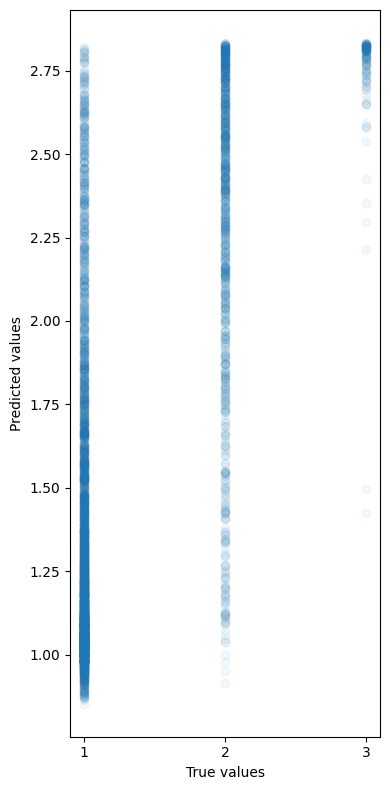

In [43]:
import datetime


results = []




# Regression
if regression:
  feature_vector = None
  gridsearch = True

  y_pred = trainer.predict(test_dataset=encoded_dataset["test"]).predictions
  y_pred = y_pred.reshape(1,-1)[0]


  y_pred_df = pd.DataFrame(y_pred)
  y_pred_df.to_csv(output_dir_i+f'y_pred_{model_name}_gridsearch-{gridsearch}_{ts_i}.csv', index=False)
  path = output_dir_i + f'scatter_{model_name}_gridsearch-{gridsearch}_{ts_i}'

  # Performance
  results_i =regression_report(y_test,y_pred,y_train=y_train,
                              metrics_to_report = metrics_to_report,
                                gridsearch=gridsearch,
                              best_params=best_params,feature_vector=feature_vector,model_name=model_name, n=n, plot = True, save_fig_path = path, round_to = 2)




  results_i.to_csv(output_dir_i + f'results_{model_name}_gridsearch-{gridsearch}_{ts_i}.csv')
  display(results_i)
  results.append(results_i)
  results_df = pd.concat(results)
  results_df = results_df.reset_index(drop=True)
  results_df.to_csv(output_dir_i + f'results_{ts_i}.csv', index=False)

else:
  # Classification
  y_pred_proba = trainer.predict(test_dataset=encoded_dataset["test"]).predictions

  y_pred_proba = np.array(y_pred_proba)
  y_pred_proba_1 = y_pred_proba[:,1]
  y_pred = [np.argmax(n) for n in y_pred_proba]

  test['y_pred_proba_0'] = y_pred_proba[:,0]
  test['y_pred_proba_1'] = y_pred_proba[:,1]
  test['y_pred'] = y_pred


  test.to_csv(output_dir_i+'test_predictions.csv', index=False)

  # y_pred = [int(np.argmax(n)) for n in y_pred_proba]
  print(metrics.classification_report(y_pred=y_pred, y_true=y_test))
  results = {}

  clf_report_sklearn = metrics.classification_report(y_test,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
  cm_df_meaning, cm_df, cm_df_norm = metrics_report_cm(y_test, y_pred, output_dir_results, model_name, ts, save=True)
  clf_report = metrics_report_classification_report(y_test,y_pred,y_pred_proba_1, output_dir_results, model_name, ts)
  # scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate
  results[model_name] = {
      'clf_report': clf_report,
      'cm_df_meaning': cm_df_meaning,
      'cm_df': cm_df,
      'cm_df_norm': cm_df_norm,
      'clf_report_sklearn': clf_report_sklearn

  }
  for k, v in results.get(model_name).items():
    print(k)
    if k != 'clf_report_sklearn':
      display(v)
    else:
      print(v)
    print()


In [44]:
# trainer.evaluate(eval_dataset=encoded_dataset["test"])
# trainer.evaluate() # this is done on the validation set specificed in the Trainer()

In [45]:
# load model:
#  - https://discuss.huggingface.co/t/how-to-save-my-model-to-use-it-later/20568/6
# - model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# - then just load the trainer, but instead of training you just predict (here I'm training to fine tune, but if we load the fine tuned model , there's no need)


